# Dashboard zur Auswertung von Rezepten

Grundlage sind die Datenbank Spoonacular sowie der Subreddit "food"

### Use Cases:
##### Reddit:
1. Postzeit (Uhrzeit) der besten Posts
2. Postzeit (Uhrzeit) der schlechtesten Posts
3. längste Zeit in Top
4. kürzeste Zeit in Top(?)
5. Länge des Titels in Bezug auf Ups/Dauer in Top
6. Kategorisierung mit NLP bzgl. Süß/Herzhaftes Gericht
7. Kategorisierung mit Bilderkennung bzgl. Süß/Herzhaftes Gericht
8. Up’s abhängig von Autor
9. Anzahl der Kommentare in Abhängigkeit von Ups
10. Anzahl der Kommentare in Abhängigkeit von Postzeit
11. Anzahl der Kommentare in Abhängigkeit von Autor
12. Anzahl der Kommentare über die Zeit
13. Anzahl der Ups über die Zeit
14. Kommentare: 
    1. Beziehung zwischen Personen erkennen/clustern


    
##### Spoonacular:
15. Anteil vegane/vegetarische/fleischlastige Gerichte
16. Anteil laktosefreie Gerichte
17. Anteil glutenfreier Gerichte
18. Bewertung im Verhältnis zu Inhaltsstoffen
    1. Zucker    
    2. Fett
    3. Kalorien
19. Zubereitungszeit in Abhängigkeit von Likes
20. Kategorisierung aufgrund von Inhaltsstoffen
21. Zubereitungszeit in Abhängigkeit von Kategorie 


##### Kombi:
22. Kombi aus Spoonacular Nr. 17 und Top 10 der letzten 24h
23. Vergleich der Beliebtheit der Rezepte: Spoonacular Likes vs. Reddit Ups


## Requirements

In [1]:
# Final Variablen
API_KEY_SPOONACULAR = "146fe79a630b4afb8306a2985bedc64c"
API_KEY_SPOONACULAR = "6e0a91c81983423792b327bc4b78bb1d"

API_KEY_REDDIT = "KAJ2xGzCOlH3hyTRADNdSBDuTBORvw"
API_CLIENTID_REDDIT = "tSemvcUBRFCTYQ"

USERNAME_REDDIT = "Short-Arrival7632"
PW_REDDIT = "cookies123"

In [2]:
# KONFIGURATION

LIMIT_REDDIT_POSTS = 100
LIMIT_SPOONACULAR_RECIPES = 100
REDDIT_SAVE_INTERVALL = 10 # Minuten

In [3]:
# Auf Windows ausführen (einmalig)
# !pip install praw
# !pip install pandas
# !pip install matplotlib
# !pip install mysql-connector-python

In [4]:
# Auf Linux ausführen (einmalig)
"""
!pip3 install praw
!pip3 install pandas
!pip3 install matplotlib
!pip3 install mysql-connector-python
"""

'\n!pip3 install praw\n!pip3 install pandas\n!pip3 install matplotlib\n!pip3 install mysql-connector-python\n'

In [5]:
import praw
import pandas as pd
from datetime import datetime, timedelta
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.dates as pdt
import mysql.connector
import re
from tqdm import tqdm

### Connect to Database

In [6]:
db_connection = mysql.connector.connect(
  host= "wp.jagi.wtf",
  user= "redditu",
  password= "redditMaster",
  database="reddit"
  )


In [7]:
cursor = db_connection.cursor()

In [8]:
db_connection.commit()

In [9]:
cursor.execute("select count(id) from reddit")

In [10]:
for blub in cursor:
    print(blub[0])

805100


### Get Data from Subreddit DB

In [11]:
dfr = pd.read_sql("SELECT * FROM reddit order by ups desc", db_connection)

### 1. Postzeit der besten Posts (0.9 Quantil)

In [12]:
dfr_wds = dfr[["title", "ups", "time_created", "hour_created", "num_comments", "author"]]
# dfr_wds = dfr_wd.sort_values("ups", ascending=False)
dfr_wods = dfr_wds.drop_duplicates(subset=["title"]).copy()
dfr_wods["time"] = pd.to_datetime(dfr_wods["time_created"])
dfr_wodss = dfr_wods[(dfr_wods["ups"]>dfr_wods["ups"].quantile(0.9))].copy()
dfr_wodsl = dfr_wods[dfr_wods["ups"]<dfr_wods["ups"].quantile(0.1)].copy()
hour_dict = dfr_wodss.value_counts(subset=["hour_created"]).to_dict()
#hour_dict

In [13]:
# testdf = dfr_wds[["time_created", "title"]].copy()
# testdf.drop_duplicates(subset=["title"], inplace=True)
# print(testdf.describe())
# #testdf.reset_index(testdf["time_created"], inplace=True)
# testdf.head()

In [14]:
# testdf = dfr_wods.copy()
# testdf["time_created"] = pd.to_datetime(testdf["time"])
# testdf["hour_created"] = testdf["time_created"].dt.hour 
# testdf = testdf.sort_values("hour_created", ascending=True)
 
# testdf["rolling"] = testdf["hour_created"].rolling(window=10, min_periods=0).mean() 

In [15]:
# vals = sorted(testdf["hour_created"].value_counts().to_dict().items())
# h = []
# c = []
# for pair in vals:
#     h.append(pair[0])
#     c.append(pair[1])
# h = pd.to_datetime(h)

In [16]:
# pd.to_numeric(dfr_wodsl["hour_created"])
# print(range(24))

### 2. Postzeit Beste (>0.9 Quantil) vs Schlechteste (<0.1 Quantil) Posts

/home/jakob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


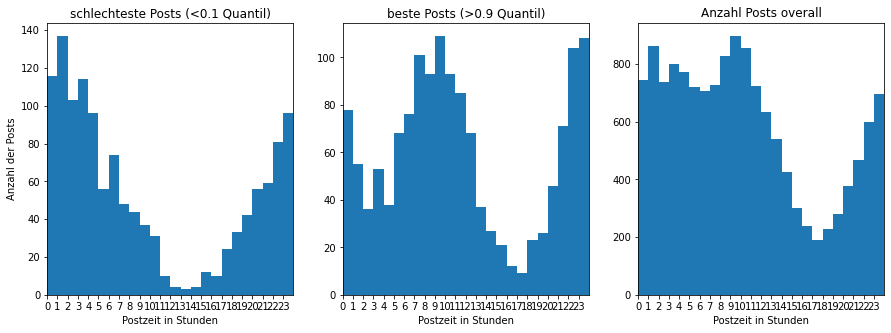

In [17]:
#plt.scatter(dfr_wodsl["time"], dfr_wodsl["ups"])
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=False, figsize=(15,5))

ax1.set_title("schlechteste Posts (<0.1 Quantil)")
ax1.hist(pd.to_numeric(dfr_wodsl["hour_created"]), bins=range(25))
ax1.set_xlabel("Postzeit in Stunden")
ax1.set_xticks(range(24))
ax1.set_xlim([0,24])
ax1.set_ylabel("Anzahl der Posts")

ax2.set_title("beste Posts (>0.9 Quantil)")
ax2.hist(pd.to_numeric(dfr_wodss["hour_created"]), bins=range(25))
ax2.set_xlabel("Postzeit in Stunden")
ax2.set_xticks(range(24))
ax2.set_xlim([0,24])

ax3.set_title("Anzahl Posts overall")
ax3.hist(pd.to_numeric(dfr_wods["hour_created"]), bins=range(25))
ax3.set_xlabel("Postzeit in Stunden")
ax3.set_xticks(range(24))
ax3.set_xlim([0,24])

fig.show()

### 3. längste Zeit in Top

In [18]:
dfr_wdg = dfr_wds.groupby("title")
pairs = dfr_wdg.groups

In [19]:
posts = []
for key in pairs:
    posts.append(dfr_wdg.get_group(key)[["time_created", "title", "ups"]].to_dict())

In [20]:
for post in posts:
    post["duration"] = len(post["time_created"]) * REDDIT_SAVE_INTERVALL

In [21]:
duration = []
for post in posts:
    duration.append([list(post["title"].values())[0], 
                     post["duration"], 
                     max(list(post["ups"].values())), 
                     list(post["time_created"].values())[0]])
dfrd = pd.DataFrame(duration, 
                    columns=["title", 
                             "duration_minutes", 
                             "max_ups", 
                             "time_created"])
dfrd_s = dfrd.sort_values("duration_minutes", ascending=False)
dfrd_s["posttime"] = pd.to_datetime(dfrd_s["time_created"])
dfrd_s.head()

,title,duration_minutes,max_ups,time_created,posttime
6119,[Homemade] Pizza,19870,18016,10:44:08,2021-04-11 10:44:08
2737,[Homemade] Chocolate Chip Cookies,15040,19340,07:34:42,2021-04-11 07:34:42
4871,[Homemade] Lasagna,11020,1063,09:44:15,2021-04-11 09:44:15
2281,[Homemade] Cheeseburger,9900,1665,23:39:52,2021-04-11 23:39:52
6504,[Homemade] Ratatouille,9590,4720,10:13:53,2021-04-11 10:13:53


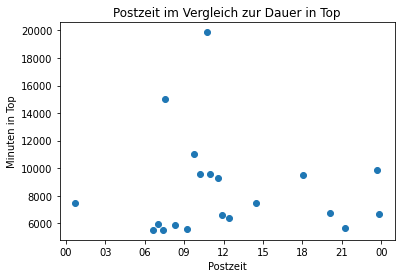

In [22]:
limit = 20
myFmt = pdt.DateFormatter("%H")
plt.scatter(dfrd_s["posttime"][:limit], dfrd_s["duration_minutes"][:limit])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title("Postzeit im Vergleich zur Dauer in Top")
plt.xlabel("Postzeit")
plt.ylabel("Minuten in Top")
plt.show()

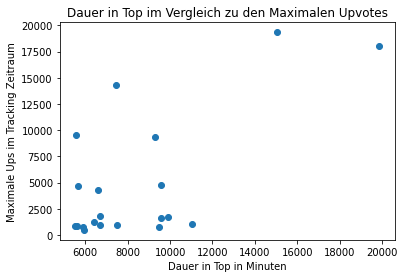

In [23]:
#limit = 20 #nur wenn nochmal verändert werden soll
plt.scatter(dfrd_s["duration_minutes"][:limit], dfrd_s["max_ups"][:limit])
plt.title("Dauer in Top im Vergleich zu den Maximalen Upvotes")
plt.xlabel("Dauer in Top in Minuten")
plt.ylabel("Maximale Ups im Tracking Zeitraum")
plt.show()

# Verlauf der Upvotes über die Zeit

In [24]:
dfru = pd.read_sql("SELECT * FROM users", db_connection)
dfru.set_index("username", inplace=True)

In [27]:
dfr["day_created"] = pd.to_datetime(dfr["day_created"]).dt.date
dfr["time_created"] = pd.to_datetime(dfr["time_created"]).dt.time
dfr["curr_time"] = pd.to_datetime(dfr["curr_time"])

In [30]:
dtstuff = dfr.apply(
    lambda row: datetime.combine(row['day_created'], row['time_created']),
    axis=1
)
dfr["time"] = dtstuff

In [68]:
dfr["time"] = dfr["time"] - timedelta(hours=10) # weil Jakob verkackt hat, die Daten in UTC Zeit zu speichern :(

In [114]:
dfr["post_id"] = dfr.agg('{0[author]}-{0[time]}'.format, axis=1) # dauert lange, ist aber wichtig

In [104]:
dfr["duration"] = dfr["curr_time"] - dfr["time"]
dfr["duration_seconds"] = dfr["duration"].dt.total_seconds()
dfr["duration_seconds"]
dfr["duration_hours"] = dfr["duration_seconds"]/3600

In [116]:
new_df = dfr.join(dfru, on="author")

In [171]:
x = new_df[["title", "duration_hours", "ups", "post_id"]].groupby('post_id')
y_high = x.filter(lambda x: x["ups"].max() > dfr_wods["ups"].quantile(0.9))
y_low = x.filter(lambda x: x["ups"].max() < dfr_wods["ups"].quantile(0.1))
y_med = x.filter(lambda x: x["ups"].max() < dfr_wods["ups"].quantile(0.9))
z = y_high.groupby("post_id")

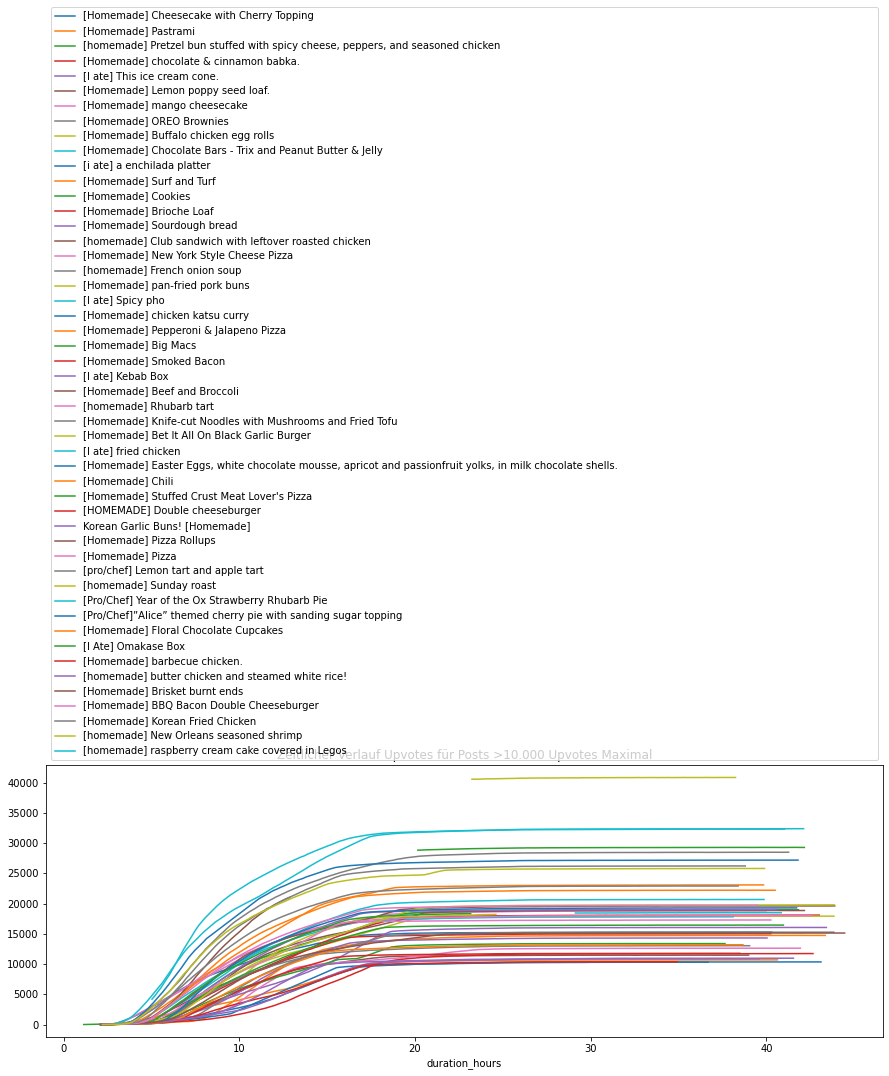

In [129]:
fig, ax = plt.subplots(figsize=(15,5))
zähler = 0
for i, k in enumerate(z):
    label, df = k
    df.sort_values(by="duration_hours", inplace=True)
    df.plot(x="duration_hours", y="ups", kind="line", ax=ax, label=df["title"].iloc[0])
    if zähler == 50:
        break
    else:
        zähler +=1
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand")
plt.title("Zeitlicher Verlauf Upvotes für Posts >10.000 Upvotes Maximal")
plt.show()


duration_hours = 0 => Eintritt in TOP. Liegt daran, dass die Erstellungszeit nicht die Zeit sein muss, zu der es in TOP erscheint.

FRAGEN:
- wie können werte gesammelt werden von vor Eintritt in TOP? => post.created != post.created_utc -.-
- wie legende hinzufügen? => mit df["title"].iloc[0]
- wieso "flackert" die Linie... => ID war nicht eindeutig/wurde falsch formatiert

# Verlauf der Upvotes im Durchschnitt

In [177]:
hour_mean = []
h_mean_y_low = []
h_mean_y_med = []
h_mean_y_high = []
h_mean_all = []
h = []

for i in range(1,40):
    hour_mean.append([i, dfr[(dfr["duration_hours"]>i) & (dfr["duration_hours"]<i+1)]["ups"].mean()])
    h_mean_y_high.append(y_high[(y_high["duration_hours"]>i) & (y_high["duration_hours"]<i+1)]["ups"].mean())
    h_mean_y_med.append(y_med[(y_med["duration_hours"]>i) & (y_med["duration_hours"]<i+1)]["ups"].mean())
    h_mean_y_low.append(y_low[(y_low["duration_hours"]>i) & (y_low["duration_hours"]<i+1)]["ups"].mean())
    
    h_mean_all.append(dfr[(dfr["duration_hours"]>i) & (dfr["duration_hours"]<i+1)]["ups"].mean())
    h.append(i)

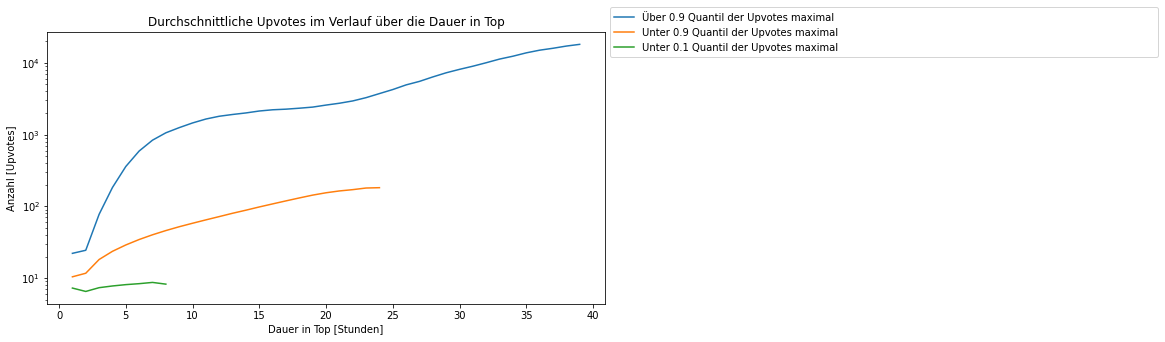

In [181]:
plt.figure(figsize=(10,5))
plt.title("Durchschnittliche Upvotes im Verlauf über die Dauer in Top")
plt.xlabel("Dauer in Top [Stunden]")
plt.ylabel("Anzahl [Upvotes]")
plt.yscale("log")

plt.plot(h, h_mean_y_high, label="Über 0.9 Quantil der Upvotes maximal")
plt.plot(h, h_mean_y_med, label="Unter 0.9 Quantil der Upvotes maximal")
plt.plot(h, h_mean_y_low, label="Unter 0.1 Quantil der Upvotes maximal")

# plt.plot(h, h_mean_all, label="Alle Posts")
plt.legend(bbox_to_anchor=(1, 1, 1, 0), loc="right", mode="expand")
plt.show()

### 4. Kürzeste Zeit in Top

In [67]:
dfrd_s[dfrd_s["duration_minutes"] == 10].describe()

,duration_minutes,max_ups
count,348.0,348.000000
mean,10.0,8.468391
std,0.0,3.160752
min,10.0,3.000000
25%,10.0,6.000000
50%,10.0,8.000000
75%,10.0,10.000000
max,10.0,19.000000


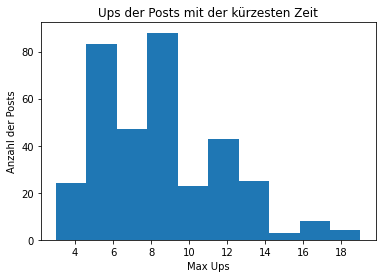

In [68]:
plt.hist(dfrd_s[dfrd_s["duration_minutes"]==10]["max_ups"])
plt.title("Ups der Posts mit der kürzesten Zeit")
plt.xlabel("Max Ups")
plt.ylabel("Anzahl der Posts")
plt.show()

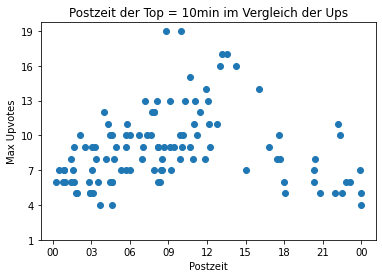

In [69]:
limit = 111
plt.scatter(dfrd_s["posttime"][-limit:], dfrd_s["max_ups"][-limit:])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title("Postzeit der Top = 10min im Vergleich der Ups")
plt.xlabel("Postzeit")
plt.ylabel("Max Upvotes")
plt.yticks([x for x in range(1,20,3)])
plt.show()

### 5.1 Länge des Titels in Bezug auf Ups

In [70]:
dfr_wods["title_length"] = dfr_wods["title"].apply(len)

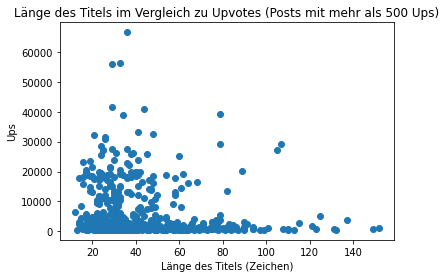

In [71]:
limit = 500
plt.scatter(dfr_wods[dfr_wods["ups"]>limit]["title_length"], 
           dfr_wods[dfr_wods["ups"]>limit]["ups"])
plt.title("Länge des Titels im Vergleich zu Upvotes (Posts mit mehr als " + str(limit) + " Ups)")
plt.xlabel("Länge des Titels (Zeichen)")
plt.ylabel("Ups")
plt.show()

### 5.2. Länge des Titels in Bezug auf Dauer in Top

In [72]:
dfrd_s["title_length"] = dfrd_s["title"].apply(len)

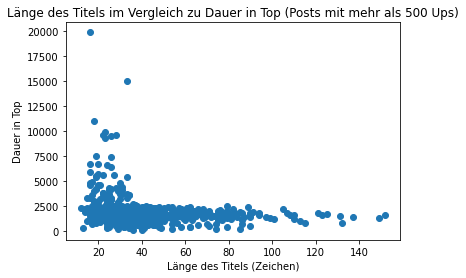

In [73]:
limit = 500
plt.scatter(dfrd_s[dfrd_s["max_ups"]>limit]["title_length"], 
           dfrd_s[dfrd_s["max_ups"]>limit]["duration_minutes"])
plt.title("Länge des Titels im Vergleich zu Dauer in Top (Posts mit mehr als " + str(limit) + " Ups)")
plt.xlabel("Länge des Titels (Zeichen)")
plt.ylabel("Dauer in Top")
plt.show()

### 6. Kategorisierung bzgl. Süß/Herzhaft (NLP)

In [74]:
# von Alex in dedizierten File

### 7. Kategorisierung bzgl. Süß/Herzhaft (Bilderkennung)

### 8. Ups abhängig vom Autor

In [75]:
author_dict = dfr_wods.value_counts(subset=["author"]).to_dict()

In [76]:
authors = []

for key in author_dict:
    author = [key[0], 
              len(dfr_wods[dfr_wods["author"]==key[0]]["ups"].index),
              dfr_wods[dfr_wods["author"]==key[0]]["ups"].sum()]
    authors.append(author)

In [77]:
dfa = pd.DataFrame(authors, columns=["author", "posts", "ups"])
dfa_s = dfa.sort_values("ups", ascending=False)
dfa_s.head()
dfa_ss = dfa_s[dfa_s["ups"]> 10000]

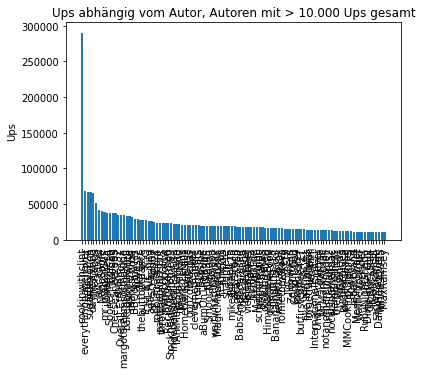

In [78]:
plt.bar(dfa_ss["author"], dfa_ss["ups"])
plt.xticks(rotation='vertical')
plt.title("Ups abhängig vom Autor, Autoren mit > 10.000 Ups gesamt")
plt.ylabel("Ups")
plt.show()

### 8.1. Anzahl Posts pro Autor in Abhängigkeit der Ups gesamt

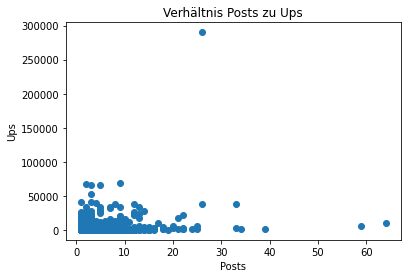

In [79]:
plt.scatter(dfa_s["posts"], dfa_s["ups"])
plt.xlabel("Posts")
plt.ylabel("Ups")
plt.title("Verhältnis Posts zu Ups")
plt.show()

### 9. Anzahl Kommentare in Abhängigkeit von Ups

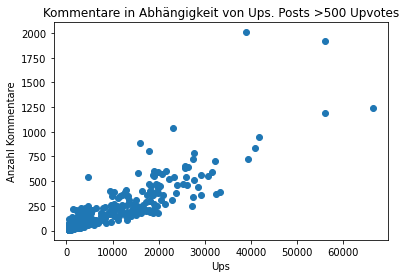

In [80]:
limit = 500
plt.scatter(dfr_wods[dfr_wods["ups"]>limit]["ups"],
           dfr_wods[dfr_wods["ups"]>limit]["num_comments"])
plt.title("Kommentare in Abhängigkeit von Ups. Posts >"+ str(limit) + " Upvotes")
plt.xlabel("Ups")
plt.ylabel("Anzahl Kommentare")
plt.show()

### 10. Anzahl Kommentare in Abhängigkeit von Postzeit

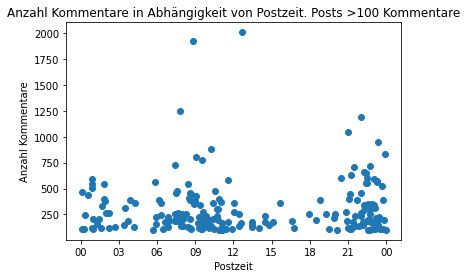

In [81]:
limit = 100
plt.scatter(dfr_wods[dfr_wods["num_comments"]>limit]["time"],
           dfr_wods[dfr_wods["num_comments"]>limit]["num_comments"])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title("Anzahl Kommentare in Abhängigkeit von Postzeit. Posts >" + str(limit) + " Kommentare")
plt.xlabel("Postzeit")
plt.ylabel("Anzahl Kommentare")
plt.show()

### 11. Anzahl Kommentare in Abhängigkeit vom Autor

In [82]:
authors2 = []

for key in author_dict:
    author = [key[0], 
              len(dfr_wods[dfr_wods["author"]==key[0]]["ups"].index),
              dfr_wods[dfr_wods["author"]==key[0]]["ups"].max(),
             dfr_wods[dfr_wods["author"]==key[0]]["num_comments"].max()]
    authors2.append(author)

In [83]:
authors2[0]

['MaxRamsey', 64, 2737, 53]

In [84]:
dfa2 = pd.DataFrame(authors2, columns=["author", "posts", "ups", "num_comments"])
dfa2_s = dfa2.sort_values("num_comments", ascending=False)

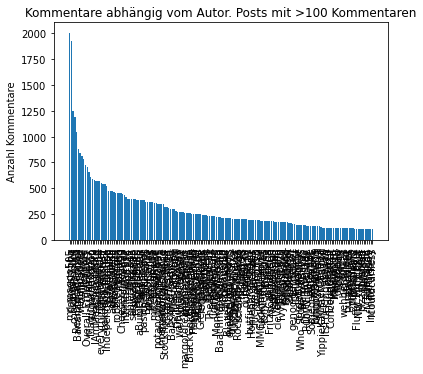

In [85]:
limit = 100
plt.bar(dfa2_s[dfa2_s["num_comments"]>limit]["author"], 
        dfa2_s[dfa2_s["num_comments"]>limit]["num_comments"])
plt.xticks(rotation='vertical')
plt.title("Kommentare abhängig vom Autor. Posts mit >" + str(limit) + " Kommentaren")
plt.ylabel("Anzahl Kommentare")
plt.show()

### 12. Anzahl Kommentare über die Zeit

In [86]:
dfr["time"] = pd.to_datetime(dfr["curr_time"])
critical_date = datetime.now() - timedelta(days=14)

NameError: name 'np' is not defined

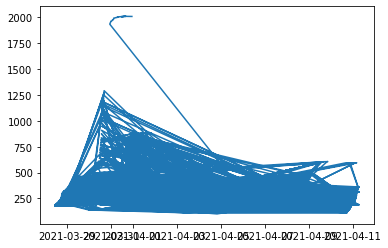

In [87]:
plt.plot(dfr[(dfr["time"]>critical_date) & (dfr["ups"]>10000)]["time"],
        dfr[(dfr["time"]>critical_date) & (dfr["ups"]>10000)]["num_comments"])
color=iter(plt.cm.rainbow(np.linspace(0,1,n)))
for i in range(n):
   c=next(color)

plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

# Lessons Learned

- Dokumentation richtig lesen!
- created time muss nicht gleich created time in utc sein (das kann Auswertungen sehr spaßig machen)
- Reposts sind doof für Analysen (wenn man nicht dran denkt)